In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

display(df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


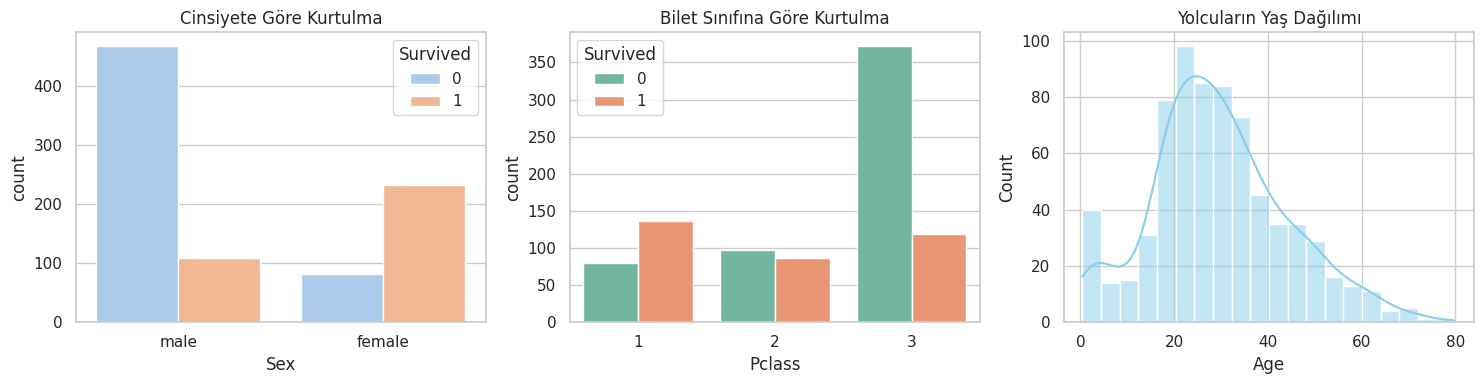

In [3]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='Sex', hue='Survived', palette='pastel')
plt.title("Cinsiyete Göre Kurtulma")

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='Pclass', hue='Survived', palette='Set2')
plt.title("Bilet Sınıfına Göre Kurtulma")

plt.subplot(1, 3, 3)
sns.histplot(data=df, x='Age', kde=True, color='skyblue')
plt.title("Yolcuların Yaş Dağılımı")

plt.tight_layout()
plt.show()

In [4]:
df_temiz = df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)

df_temiz['Age'] = df_temiz['Age'].fillna(df_temiz['Age'].median())
df_temiz['Embarked'] = df_temiz['Embarked'].fillna('S')

df_temiz['Sex'] = df_temiz['Sex'].map({'male': 0, 'female': 1})
df_temiz = pd.get_dummies(df_temiz, columns=['Embarked'], drop_first=True)

display(df_temiz.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,False,True
1,1,1,1,38.0,1,0,71.2833,False,False
2,1,3,1,26.0,0,0,7.9250,False,True
3,1,1,1,35.0,1,0,53.1000,False,True
4,0,3,0,35.0,0,0,8.0500,False,True


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = df_temiz.drop('Survived', axis=1)
y = df_temiz['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

tahminler = model.predict(X_test)
dogruluk = accuracy_score(y_test, tahminler)

print(f"Doğruluk Oranı: %{dogruluk * 100:.2f}")

Doğruluk Oranı: %79.89


In [6]:
from sklearn.model_selection import GridSearchCV

parametreler = {
    'n_estimators': [50, 100, 200],      # Ağaç sayısı
    'max_depth': [None, 5, 10, 15],      # Derinlik
    'min_samples_split': [2, 5, 10]      # Bölünme kuralı
}

grid_arama = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=parametreler,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_arama.fit(X_train, y_train)

en_iyi_model = grid_arama.best_estimator_
optimize_tahminler = en_iyi_model.predict(X_test)
optimize_dogruluk = accuracy_score(y_test, optimize_tahminler)

print(f"Optimize Edilmiş Yeni Doğruluk Oranı: %{optimize_dogruluk * 100:.2f}")
print(f"Kullanılan En İyi Ayarlar: {grid_arama.best_params_}")

Optimize Edilmiş Yeni Doğruluk Oranı: %81.56
Kullanılan En İyi Ayarlar: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}


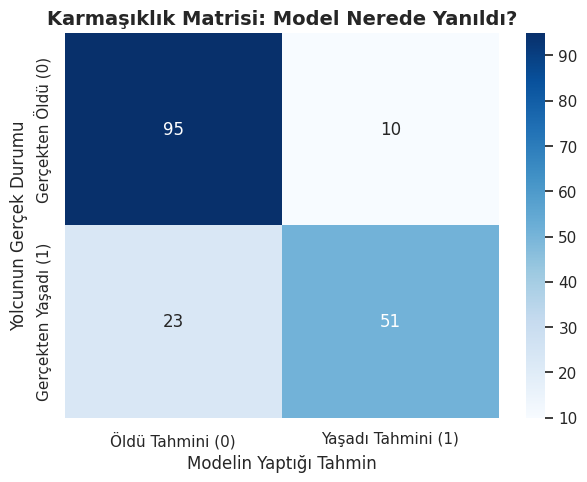

,Gerçek Durum,Modelin Tahmini,Sonuç
0,Yaşadı ✅,Öldü ❌,Yanlış Tahmin
1,Öldü ❌,Öldü ❌,Doğru tahmin
2,Öldü ❌,Öldü ❌,Doğru tahmin
3,Yaşadı ✅,Yaşadı ✅,Doğru tahmin
4,Yaşadı ✅,Yaşadı ✅,Doğru tahmin
5,Yaşadı ✅,Yaşadı ✅,Doğru tahmin
6,Yaşadı ✅,Yaşadı ✅,Doğru tahmin
7,Öldü ❌,Öldü ❌,Doğru tahmin
8,Yaşadı ✅,Yaşadı ✅,Doğru tahmin
9,Yaşadı ✅,Yaşadı ✅,Doğru tahmin


In [7]:
from sklearn.metrics import confusion_matrix

matris = confusion_matrix(y_test, optimize_tahminler)
plt.figure(figsize=(7, 5))

sns.heatmap(matris, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Öldü Tahmini (0)', 'Yaşadı Tahmini (1)'],
            yticklabels=['Gerçekten Öldü (0)', 'Gerçekten Yaşadı (1)'])

plt.title('Karmaşıklık Matrisi: Model Nerede Yanıldı?', fontsize=14, fontweight='bold')
plt.xlabel('Modelin Yaptığı Tahmin', fontsize=12)
plt.ylabel('Yolcunun Gerçek Durumu', fontsize=12)
plt.show()

ornek_sonuclar = pd.DataFrame({
    'Gerçek Durum': y_test.values[:10],
    'Modelin Tahmini': optimize_tahminler[:10]
})

ornek_sonuclar['Gerçek Durum'] = ornek_sonuclar['Gerçek Durum'].map({0: 'Öldü ❌', 1: 'Yaşadı ✅'})
ornek_sonuclar['Modelin Tahmini'] = ornek_sonuclar['Modelin Tahmini'].map({0: 'Öldü ❌', 1: 'Yaşadı ✅'})
ornek_sonuclar['Sonuç'] = ornek_sonuclar.apply(lambda row: 'Doğru tahmin' if row['Gerçek Durum'] == row['Modelin Tahmini'] else 'Yanlış Tahmin', axis=1)

display(ornek_sonuclar)